In [19]:
import sys
import ftplib
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [20]:
#connect to ftp and get the list of samples
ftp_url = 'ftp.pride.ebi.ac.uk'
samples_dir = 'pride/data/proteomes/proteogenomics/cell-lines'
id_dir = 'proteomics_lfq'
peps_file = 'out_triqler.tsv'

output_file = 'identified_peptides.tsv'

try:
    ftp = ftplib.FTP(ftp_url, timeout=3600)
    ftp.login()
    ftp.cwd(samples_dir)
    samples_list = ftp.nlst()
except ftplib.all_errors:
    print('Failed to connect to the ftp site')

print(samples_list)

['PXD003209-Sample-1', 'PXD005698-Sample-1', 'PXD005698-Sample-4', 'PXD005946-Sample-1', 'PXD005946-Sample-10', 'PXD005946-Sample-11', 'PXD005946-Sample-12', 'PXD005946-Sample-13', 'PXD005946-Sample-15', 'PXD005946-Sample-16', 'PXD005946-Sample-17', 'PXD005946-Sample-18', 'PXD005946-Sample-19', 'PXD005946-Sample-20', 'PXD005946-Sample-21', 'PXD005946-Sample-22', 'PXD005946-Sample-23', 'PXD005946-Sample-24', 'PXD005946-Sample-39', 'PXD012255-Sample-1', 'PXD015270-Sample-1']


In [21]:
#increase max limit to get larger files
ftplib.FTP.maxline = 100000

#get all peptides from the finished samples
peps_df = pd.DataFrame()
samples = []
for sample in samples_list:
    peps = []
    try:
        ftp.retrlines('RETR {}/{}/{}'.format(sample, id_dir, peps_file), peps.append)
        df = pd.DataFrame(data=[x.split('\t') for x in peps[1::]], 
                          index=[sample for x in peps[1::]],
                          columns = peps[0].split('\t'))
        df['Sample'] = sample
    except ftplib.error_perm as e: #the search is not done yet!
        print('failed to extract all lines from {}, error:{}'.format(sample, e))
        continue #to next sample
    peps_df = pd.concat([peps_df, df])
    
print(peps_df.head(2))

print('\nExtracted {} peptides from these {} samples:{}\n'.format(len(peps_df), len(set(peps_df.index)), '\n'.join(set(peps_df.index))))

failed to extract all lines from PXD005698-Sample-4, error:550 Failed to open file.
failed to extract all lines from PXD005946-Sample-12, error:550 Failed to open file.
failed to extract all lines from PXD005946-Sample-17, error:550 Failed to open file.
failed to extract all lines from PXD012255-Sample-1, error:550 Failed to open file.
                   run condition charge searchScore    intensity  \
PXD003209-Sample-1   1      HeLa      2     0.99381  2.888641e06   
PXD003209-Sample-1   2      HeLa      2     0.99381   2.69095e06   

                                       peptide  \
PXD003209-Sample-1  .(Gln->pyro-Glu)QAAEALDAAK   
PXD003209-Sample-1  .(Gln->pyro-Glu)QAAEALDAAK   

                                                             proteins  \
PXD003209-Sample-1  ENSP00000295463.3;altorf_ENST00000295463.4_3_c...   
PXD003209-Sample-1  ENSP00000295463.3;altorf_ENST00000295463.4_3_c...   

                                Sample  
PXD003209-Sample-1  PXD003209-Sample-1  
PXD0

In [22]:
#close ftp connection
ftp.close()

In [23]:
peps_df.to_csv(output_file, sep='\t', index=False)

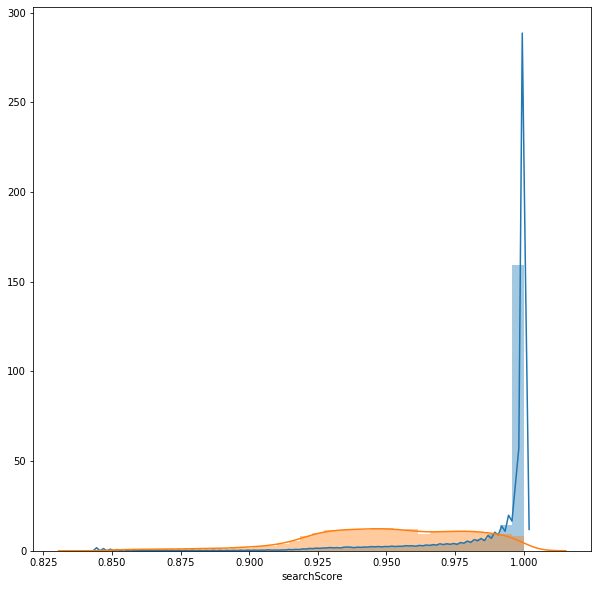

In [30]:
# This plot is for the ditribution of scores of DECOY vs TARGET 

target = peps_df.loc[peps_df.proteins.str.contains("DECOY") == False]
decoy = peps_df.loc[peps_df.proteins.str.contains("DECOY") == True]

plt.figure(figsize=(10, 10))
sns.distplot(target['searchScore'], hist=True, kde=True, 
             bins=int(180/5))
sns.distplot(decoy['searchScore'], hist=True, kde=True, 
             bins=int(180/5))

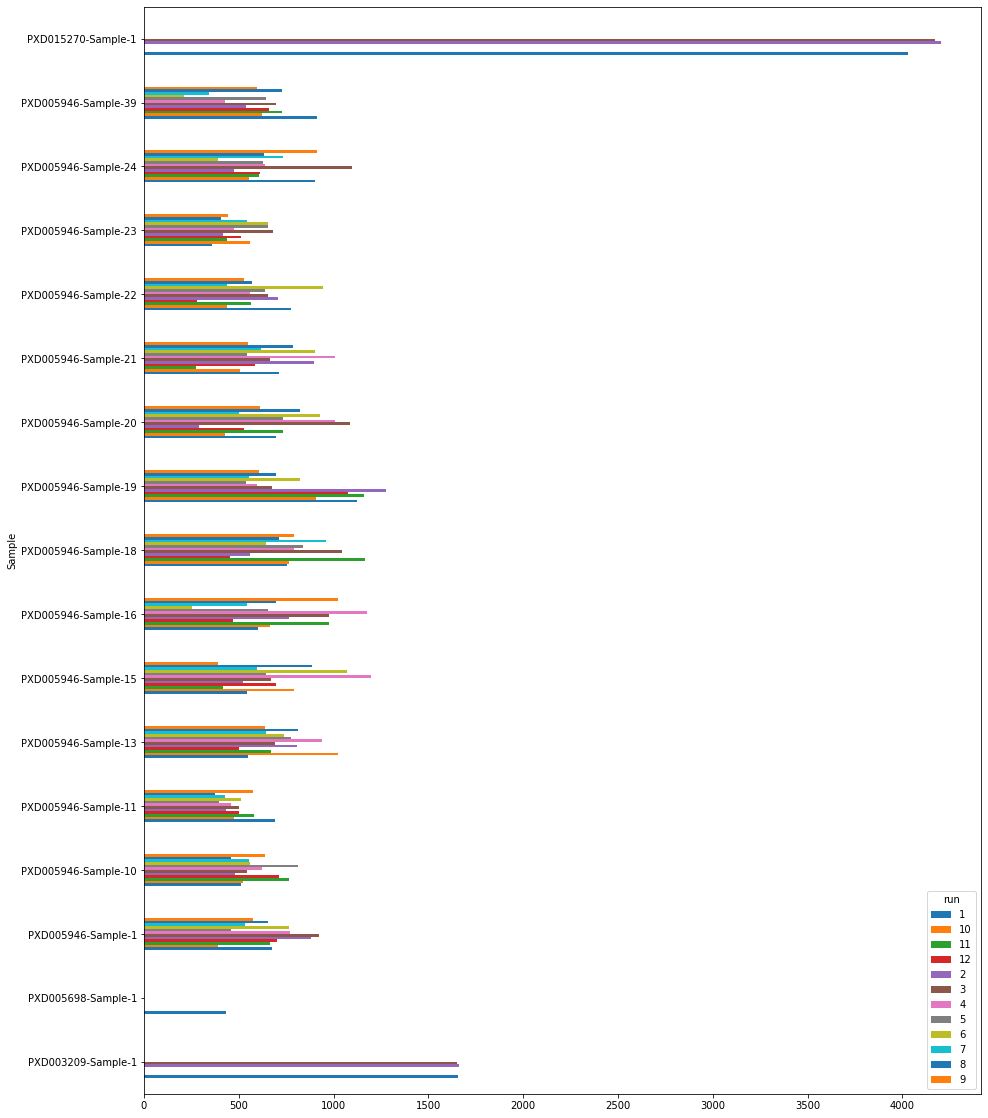

In [36]:
target
plt.rcParams["figure.figsize"] = [15, 20]
target.groupby('run').Sample.value_counts().unstack(0).plot.barh()